# Atividade Ponderada Semana 4 - Competição de Modelos Preditivos no Kaggle  

**Aluno**: André Lobo

## Visão Geral

Este notebook contém a solução completa para a competição de modelos preditivos no Kaggle. Nosso objetivo é prever a popularidade de músicas utilizando um conjunto de dados fornecido, e aplicamos diversas técnicas de pré-processamento, modelagem e validação cruzada.

### Abordagem

Optamos por utilizar a técnica de **ensemble stacking**, combinando dois modelos principais:
- **Regressão Logística**
- **Ridge Classifier**

Cada um desses modelos foi ajustado individualmente com o uso de **GridSearchCV** para garantir que os melhores hiperparâmetros fossem escolhidos. Em seguida, treinamos um **meta-modelo** (Ridge Classifier) para empilhar as previsões desses dois classificadores base, aumentando a robustez do modelo final.

### Tratamento dos Outliers

Para o tratamento de outliers, optamos pela **Winsorização Manual**. Esta abordagem foi escolhida por permitir que limitássemos os valores extremos sem removê-los completamente do conjunto de dados, preservando assim a integridade dos dados ao mesmo tempo em que evitamos distorções causadas por outliers severos.

### Pré-processamento

Utilizamos o **RobustScaler** no pré-processamento das features numéricas, pois ele é mais resistente a outliers em comparação com outras técnicas de escalonamento, como StandardScaler. Para as features categóricas, aplicamos **OneHotEncoding**, que transformou as variáveis em representações binárias, permitindo que fossem utilizadas pelos modelos de machine learning.

### Validação e Métricas

O processo de validação foi feito com o uso de **StratifiedKFold** com 20 dobras, garantindo que as classes fossem distribuídas de forma equilibrada em cada divisão de treino e teste. Avaliamos o desempenho de cada modelo individualmente, calculando métricas como **Acurácia**, **Precisão**, **Recall** e **F1-Score**.

### Tuning dos Hiperparâmetros

Realizamos o ajuste fino dos hiperparâmetros para os modelos principais (Logistic Regression e Ridge Classifier) usando **GridSearchCV**. Cada modelo foi submetido a uma série de testes com diferentes configurações de parâmetros para garantir o melhor desempenho possível.

### Conclusão

O modelo final combina o melhor de cada abordagem, utilizando um método de empilhamento (stacking) para agregar os resultados dos classificadores base. O uso de técnicas de pré-processamento adequadas, tratamento de outliers e tuning de hiperparâmetros resultou em um modelo robusto e eficiente para a tarefa de predição da popularidade de músicas.


Começamos importando todas as bibliotecas necessárias para manipulação de dados, criação de modelos de machine learning, e visualização de dados.

In [ ]:
# Importar as bibliotecas principais para manipulação de dados e criação de modelos
import pandas as pd  # Para carregar e manipular os dados
import numpy as np  # Para operações matemáticas e funções úteis como média e desvio padrão

# Importar os módulos de machine learning necessários
from sklearn.model_selection import StratifiedKFold  # Para fazer a validação cruzada com estratificação
from sklearn.linear_model import LogisticRegression, RidgeClassifier  # Para criar modelos de regressão logística e Ridge
from sklearn.ensemble import StackingClassifier  # Para criar modelos de ensemble e stacking
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # Para avaliar as métricas de desempenho dos modelos

# Importar os módulos de pré-processamento
from sklearn.preprocessing import RobustScaler, OneHotEncoder  # Para normalizar os dados e codificar variáveis categóricas
from sklearn.compose import ColumnTransformer  # Para aplicar diferentes pré-processamentos a diferentes colunas
from sklearn.pipeline import Pipeline  # Para facilitar o fluxo do processo de modelagem, incluindo pré-processamento e treinamento

# Importar bibliotecas para visualização de dados
import matplotlib.pyplot as plt  # Para criar gráficos
import seaborn as sns  # Para criar gráficos estatísticos com maior facilidade


Carregamos o dataset train.csv e exibimos as primeiras 5 linhas para inspecionar a estrutura e verificar as colunas disponíveis.

In [ ]:
# Carregar o dataset e visualizar as primeiras linhas
df = pd.read_csv('train.csv')

# Exibir as primeiras 5 linhas do dataset para inspecionar sua estrutura
df.head()

,track_unique_id,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_target
0,41996,7hUhmkALyQ8SX9mJs5XI3D,Love and Rockets,Love and Rockets,Motorcycle,211533,False,0.305,0.8490,9,...,1,0.0549,0.000058,0.056700,0.4640,0.3200,141.793,4,goth,0
1,76471,5x59U89ZnjZXuNAAlc8X1u,Filippa Giordano,Filippa Giordano,"Addio del passato - From ""La traviata""",196000,False,0.287,0.1900,7,...,0,0.0370,0.930000,0.000356,0.0834,0.1330,83.685,4,opera,0
2,54809,70Vng5jLzoJLmeLu3ayBQq,Susumu Yokota,Symbol,Purple Rose Minuet,216506,False,0.583,0.5090,1,...,1,0.0362,0.777000,0.202000,0.1150,0.5440,90.459,3,idm,1
3,16326,1cRfzLJapgtwJ61xszs37b,Franz Liszt;YUNDI,Relajación y siestas,"Liebeslied (Widmung), S. 566",218346,False,0.163,0.0368,8,...,1,0.0472,0.991000,0.899000,0.1070,0.0387,69.442,3,classical,0
4,109799,47d5lYjbiMy0EdMRV8lRou,Scooter,Scooter Forever,The Darkside,173160,False,0.647,0.9210,2,...,1,0.1850,0.000939,0.371000,0.1310,0.1710,137.981,4,techno,0


Neste bloco de código, removemos do dataset df as colunas:

'track_id' e 'track_unique_id' — ambas são identificadores únicos que não têm utilidade na análise preditiva.

'track_name' — o nome da música, que é apenas um rótulo e não contribui para a previsão da popularidade.

In [ ]:
# Remover as colunas 'track_id', 'track_unique_id' e 'track_name'
df.drop(columns=['track_id', 'track_unique_id', 'track_name'])

,artists,album_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_target
0,Love and Rockets,Love and Rockets,211533,False,0.305,0.84900,9,-10.795,1,0.0549,0.000058,0.056700,0.4640,0.3200,141.793,4,goth,0
1,Filippa Giordano,Filippa Giordano,196000,False,0.287,0.19000,7,-12.030,0,0.0370,0.930000,0.000356,0.0834,0.1330,83.685,4,opera,0
2,Susumu Yokota,Symbol,216506,False,0.583,0.50900,1,-9.661,1,0.0362,0.777000,0.202000,0.1150,0.5440,90.459,3,idm,1
3,Franz Liszt;YUNDI,Relajación y siestas,218346,False,0.163,0.03680,8,-23.149,1,0.0472,0.991000,0.899000,0.1070,0.0387,69.442,3,classical,0
4,Scooter,Scooter Forever,173160,False,0.647,0.92100,2,-7.294,1,0.1850,0.000939,0.371000,0.1310,0.1710,137.981,4,techno,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79795,Amilcare Ponchielli;Gothenburg Symphony Orches...,"Ballet Highlights - The Nutcracker, Romeo & Ju...",162613,False,0.554,0.00763,4,-30.566,1,0.0502,0.915000,0.000970,0.2210,0.1560,119.502,4,opera,1
79796,Sajanka,Time of India,240062,False,0.689,0.55400,9,-8.200,1,0.0759,0.091000,0.914000,0.0867,0.1630,148.002,4,trance,0
79797,Frankie Valli & The Four Seasons,Merry Christmas,136306,False,0.629,0.56000,0,-11.455,0,0.0523,0.595000,0.000000,0.1820,0.8800,118.895,3,soul,0
79798,The Mayries,I Will Wait,216841,False,0.421,0.10700,6,-15.191,1,0.0335,0.948000,0.000000,0.0881,0.1180,104.218,4,acoustic,1


Aqui verificamos o número de valores nulos em cada feature.

In [ ]:
# Verificar valores nulos em cada feature
missing_values = df.isnull().sum()

# Exibir as features com seus respectivos totais de valores nulos
print(missing_values)

track_unique_id      0
track_id             0
artists              0
album_name           0
track_name           0
duration_ms          0
explicit             0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
track_genre          0
popularity_target    0
dtype: int64


Neste código, usamos o método do intervalo interquartil (IQR) para detectar outliers em features numéricas.

In [ ]:
# Função para identificar outliers usando o método IQR
def detect_outliers_iqr(df, columns):
    outliers = pd.DataFrame()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = ((df[col] < lower_bound) | (df[col] > upper_bound))
    return outliers.sum()

# Colunas numéricas
numerical_columns = ['danceability', 'loudness', 'mode', 'speechiness', 'acousticness', 'liveness', 'valence']

# Verificar outliers em cada coluna numérica
outliers_count = detect_outliers_iqr(df, numerical_columns)

# Exibir o total de outliers por coluna
print(outliers_count)

danceability     420
loudness        4351
mode               0
speechiness     9277
acousticness       0
liveness        6032
valence            0
dtype: int64


Aqui, criamos uma cópia do dataset original (df) para realizar a análise exploratória dos dados (EDA) por meio de gráficos.

In [ ]:
# Criar uma cópia limpa para não modificar o dataset original
train_data_cleaned = df.copy()

Neste bloco, realizamos a análise exploratória dos dados (EDA) por meio de gráficos. Visualizamos a relação entre diversas features e a popularidade

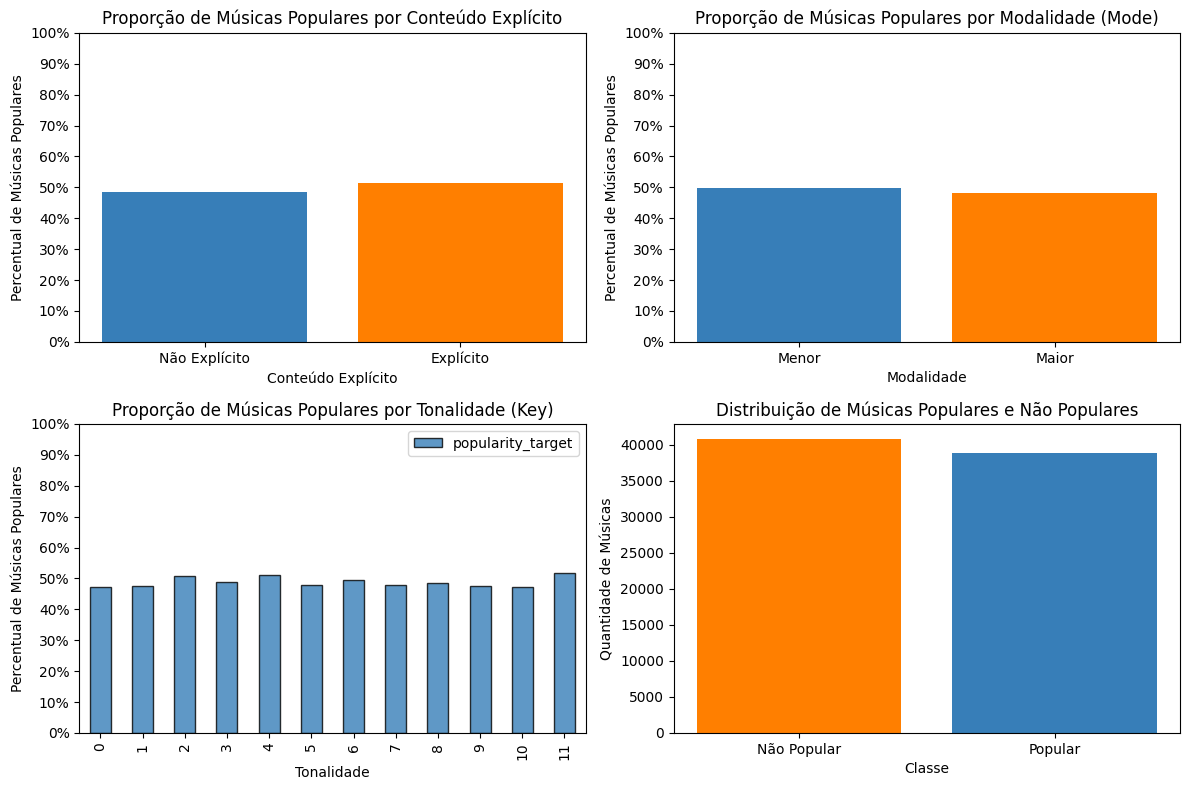

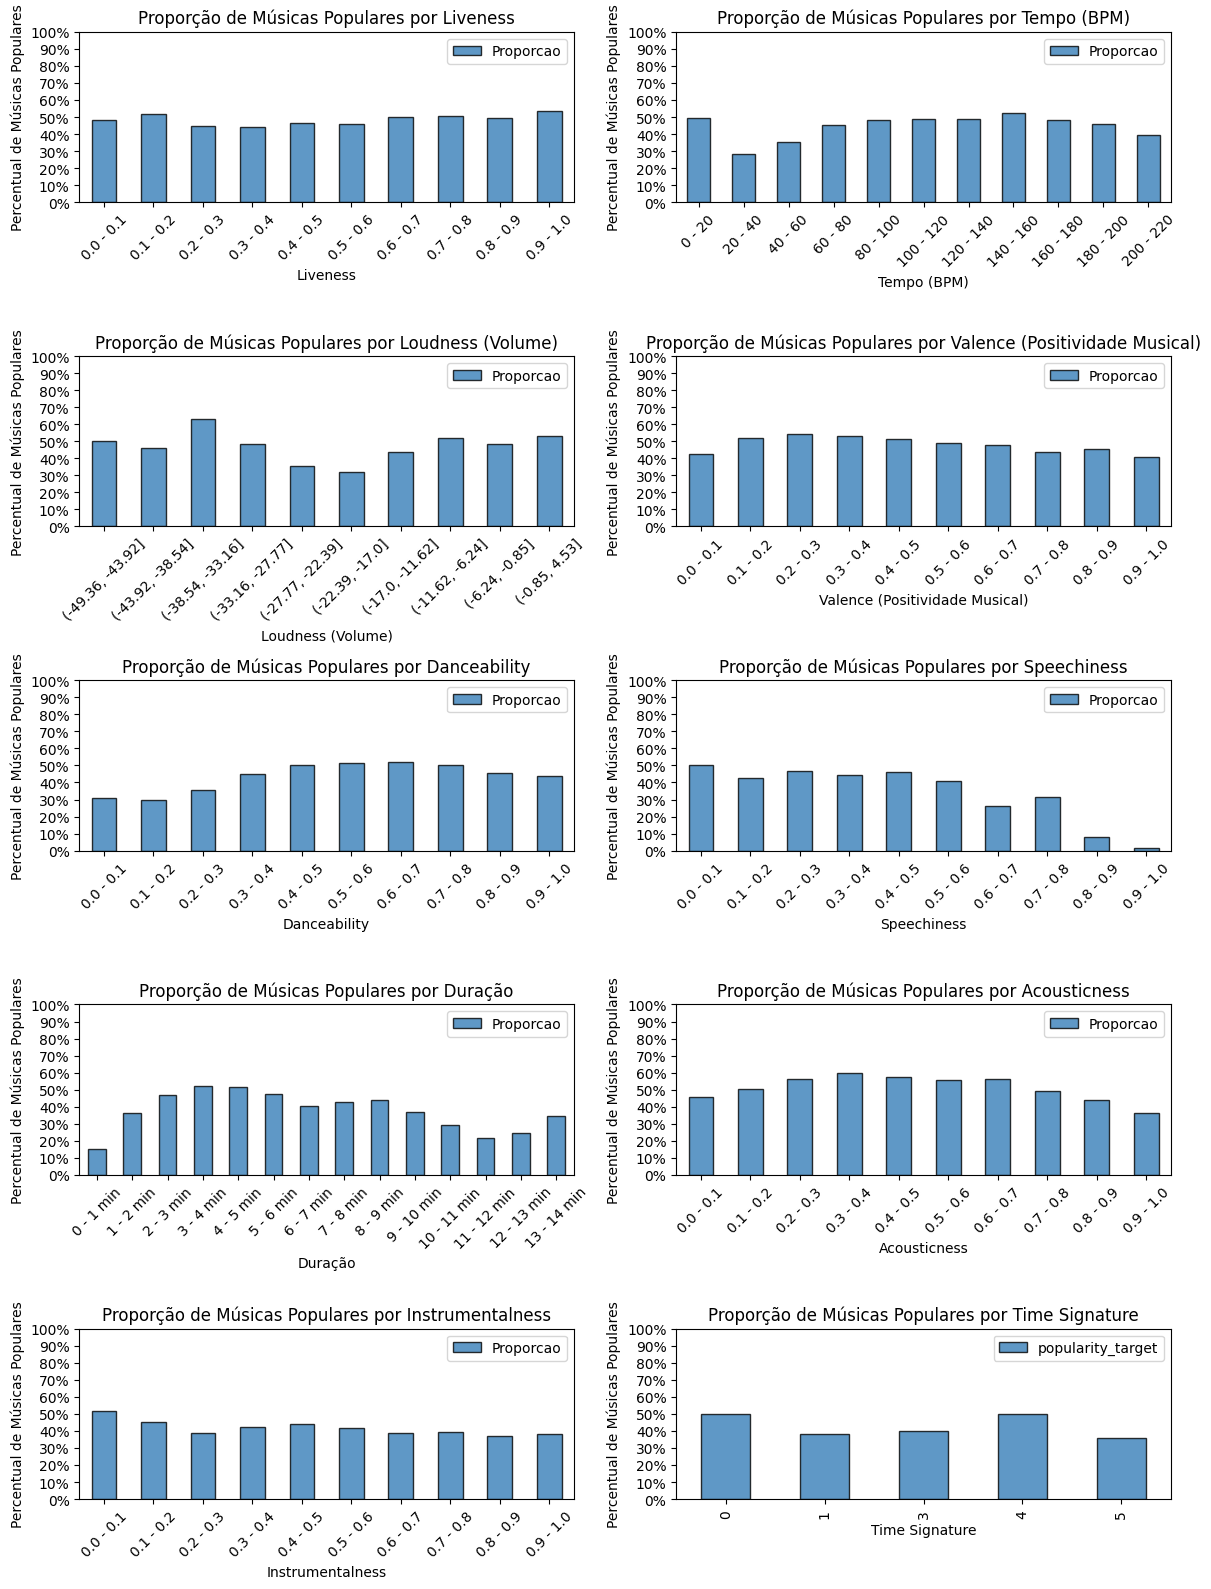

In [ ]:
# Função para criar gráficos de barras por feature com subplots
def plot_feature_by_popularity_subplot(ax, feature, bins, labels, xlabel, ylabel='Percentual de Músicas Populares'):
    # Categorizar os dados da feature
    feature_bins = pd.cut(train_data_cleaned[feature], bins=bins, labels=labels, include_lowest=True)

    # Calcular a proporção de popularidade em cada intervalo da feature
    proporcao_feature = train_data_cleaned.groupby(feature_bins, observed=True)['popularity_target'].mean()

    # Criar DataFrame para visualização
    df_feature = proporcao_feature.reset_index()
    df_feature['Proporcao'] = proporcao_feature.values

    # Plotar o gráfico de barras
    df_feature.plot(kind='bar', x=feature, y='Proporcao', color='#377eb8', alpha=0.8, edgecolor='black', ax=ax)

    # Configurações do gráfico
    ax.set_title(f'Proporção de Músicas Populares por {xlabel}')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(0, 1)
    ax.set_yticks([i / 10 for i in range(0, 11)])
    ax.set_yticklabels([f'{i*10}%' for i in range(0, 11)])
    ax.tick_params(axis='x', rotation=45)


# GRUPO 1: Gráficos Binários (2 colunas, 2 linhas)
fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # 2 linhas, 2 colunas de gráficos binários

# 1. Gráfico para Explicit (Conteúdo Explícito)
explicit_counts = train_data_cleaned.groupby('explicit')['popularity_target'].mean().reset_index()
axs[0, 0].bar(explicit_counts['explicit'].map({False: 'Não Explícito', True: 'Explícito'}),
              explicit_counts['popularity_target'], color=['#377eb8', '#ff7f00'])
axs[0, 0].set_title('Proporção de Músicas Populares por Conteúdo Explícito')
axs[0, 0].set_xlabel('Conteúdo Explícito')
axs[0, 0].set_ylabel('Percentual de Músicas Populares')
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_yticks([i / 10 for i in range(0, 11)])
axs[0, 0].set_yticklabels([f'{i*10}%' for i in range(0, 11)])

# 2. Gráfico para Mode (Modalidade)
mode_counts = train_data_cleaned.groupby('mode')['popularity_target'].mean().reset_index()
axs[0, 1].bar(mode_counts['mode'].map({0: 'Menor', 1: 'Maior'}),
              mode_counts['popularity_target'], color=['#377eb8', '#ff7f00'])
axs[0, 1].set_title('Proporção de Músicas Populares por Modalidade (Mode)')
axs[0, 1].set_xlabel('Modalidade')
axs[0, 1].set_ylabel('Percentual de Músicas Populares')
axs[0, 1].set_ylim(0, 1)
axs[0, 1].set_yticks([i / 10 for i in range(0, 11)])
axs[0, 1].set_yticklabels([f'{i*10}%' for i in range(0, 11)])

# 3. Gráfico para Tonalidade (Key)
key_counts = train_data_cleaned.groupby('key')['popularity_target'].mean().reset_index()
key_counts.plot(kind='bar', x='key', y='popularity_target', color='#377eb8', alpha=0.8, edgecolor='black', ax=axs[1, 0])
axs[1, 0].set_title('Proporção de Músicas Populares por Tonalidade (Key)')
axs[1, 0].set_xlabel('Tonalidade')
axs[1, 0].set_ylabel('Percentual de Músicas Populares')
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_yticks([i / 10 for i in range(0, 11)])
axs[1, 0].set_yticklabels([f'{i*10}%' for i in range(0, 11)])

# 4. Gráfico do Balanceamento das Classes
class_counts = train_data_cleaned['popularity_target'].value_counts()
axs[1, 1].bar(class_counts.index.map({0: 'Não Popular', 1: 'Popular'}),
              class_counts.values, color=['#ff7f00', '#377eb8'])
axs[1, 1].set_title('Distribuição de Músicas Populares e Não Populares')
axs[1, 1].set_xlabel('Classe')
axs[1, 1].set_ylabel('Quantidade de Músicas')

plt.tight_layout()
plt.show()

# GRUPO 2: Gráficos Contínuos (2 colunas, 5 linhas)
fig, axs = plt.subplots(5, 2, figsize=(12, 16))  # 5 linhas, 2 colunas de gráficos contínuos

# 1. Liveness
bins_liveness = [i/10 for i in range(11)]
labels_liveness = [f'{round(i/10, 2)} - {round((i+1)/10, 2)}' for i in range(10)]
plot_feature_by_popularity_subplot(axs[0, 0], 'liveness', bins_liveness, labels_liveness, 'Liveness')

# 2. Tempo (BPM)
bins_tempo = list(range(int(train_data_cleaned['tempo'].min()), int(train_data_cleaned['tempo'].max()), 20))
labels_tempo = [f'{i} - {i+20}' for i in bins_tempo[:-1]]
plot_feature_by_popularity_subplot(axs[0, 1], 'tempo', bins_tempo, labels_tempo, 'Tempo (BPM)')

# 3. Loudness
bins_loudness = pd.cut(train_data_cleaned['loudness'], bins=10, precision=2)
labels_loudness = [f'{round(b.left, 2)} - {round(b.right, 2)}' for b in bins_loudness.cat.categories]
train_data_cleaned['loudness_bins'] = pd.cut(train_data_cleaned['loudness'], bins=10, precision=2)
plot_feature_by_popularity_subplot(axs[1, 0], 'loudness', bins_loudness.cat.categories, labels_loudness, 'Loudness (Volume)')

# 4. Valence (Positividade musical)
bins_valence = [i/10 for i in range(11)]
labels_valence = [f'{round(i/10, 2)} - {round((i+1)/10, 2)}' for i in range(10)]
plot_feature_by_popularity_subplot(axs[1, 1], 'valence', bins_valence, labels_valence, 'Valence (Positividade Musical)')

# 5. Danceability
bins_danceability = [i/10 for i in range(11)]
labels_danceability = [f'{round(i/10, 2)} - {round((i+1)/10, 2)}' for i in range(10)]
plot_feature_by_popularity_subplot(axs[2, 0], 'danceability', bins_danceability, labels_danceability, 'Danceability')

# 6. Speechiness
bins_speechiness = [i/10 for i in range(11)]
labels_speechiness = [f'{round(i/10, 2)} - {round((i+1)/10, 2)}' for i in range(10)]
plot_feature_by_popularity_subplot(axs[2, 1], 'speechiness', bins_speechiness, labels_speechiness, 'Speechiness')

# 7. Duration (min)
train_data_cleaned['duration_min'] = train_data_cleaned['duration_ms'] / 60000
bins_duration_min = list(range(-1, 15))
labels_duration_min = [f'{i} - {i+1} min' for i in bins_duration_min[:-1]]
plot_feature_by_popularity_subplot(axs[3, 0], 'duration_min', bins_duration_min, labels_duration_min, 'Duração')

# 8. Acousticness
bins_acousticness = [i/10 for i in range(11)]
labels_acousticness = [f'{round(i/10, 2)} - {round((i+1)/10, 2)}' for i in range(10)]
plot_feature_by_popularity_subplot(axs[3, 1], 'acousticness', bins_acousticness, labels_acousticness, 'Acousticness')

# 9. Instrumentalness
bins_instrumentalness = [i/10 for i in range(11)]
labels_instrumentalness = [f'{round(i/10, 2)} - {round((i+1)/10, 2)}' for i in range(10)]
plot_feature_by_popularity_subplot(axs[4, 0], 'instrumentalness', bins_instrumentalness, labels_instrumentalness, 'Instrumentalness')

# 10. Time Signature
time_signature_counts = train_data_cleaned.groupby('time_signature')['popularity_target'].mean().reset_index()
time_signature_counts.plot(kind='bar', x='time_signature', y='popularity_target', color='#377eb8', alpha=0.8, edgecolor='black', ax=axs[4, 1])
axs[4, 1].set_title('Proporção de Músicas Populares por Time Signature')
axs[4, 1].set_xlabel('Time Signature')
axs[4, 1].set_ylabel('Percentual de Músicas Populares')
axs[4, 1].set_ylim(0, 1)
axs[4, 1].set_yticks([i / 10 for i in range(0, 11)])
axs[4, 1].set_yticklabels([f'{i*10}%' for i in range(0, 11)])

plt.tight_layout()
plt.show()

Neste bloco plotamos a matriz de correlação das features

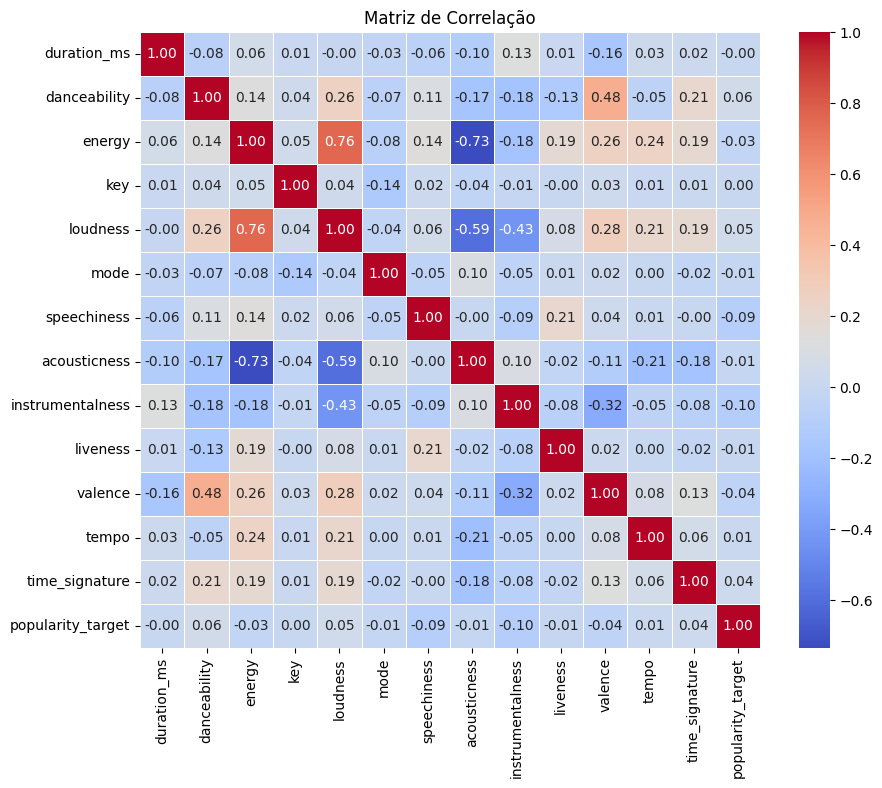

In [ ]:
# Filtrar apenas as colunas numéricas do dataset original, excluindo 'track_unique_id'
numeric_columns = df.select_dtypes(include=[np.number]).drop(columns=['track_unique_id'])

# Calcular a matriz de correlação
correlation_matrix = numeric_columns.corr()

# Plotar a matriz de correlação usando um heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

## Conclusões a partir dos gráficos

### Hipótese Número 1: Energy influencia pouco na popularidade das músicas.

- **Energy** possui uma correlação de 0.06 com a variável `popularity_target`. Apesar de ser uma característica intuitivamente importante, a análise gráfica e a matriz de correlação indicam que o impacto é muito pequeno.

- **Conclusão**: Esta feature poderia ser mantida para avaliações futuras, mas o impacto é baixo, o que pode levar à sua exclusão em estágios posteriores.

### Hipótese Número 2: Instrumentalness tem pouco ou nenhum impacto na popularidade.

- A **correlação** de **-0.05** com `popularity_target` indica que a **Instrumentalness** tem uma relação negativa fraca com a popularidade.

- O gráfico não apresenta variação significativa nos níveis de instrumentalidade em relação à popularidade.

- **Conclusão**: Forte candidata à remoção.

### Hipótese Número 3: Time Signature não é um fator determinante para a popularidade.

- **Time Signature** tem uma correlação de apenas **0.04** com a variável alvo, e o gráfico também não sugere uma relação clara.

- **Conclusão**: Considerada uma feature irrelevante, também candidata à remoção.

### Hipótese Número 4: Duration (ms) não afeta significativamente a popularidade de uma música.

- A **Duration (ms)** tem uma **correlação de 0.00** com a popularidade. Mesmo após converter a duração para minutos, o gráfico não demonstra variações significativas em relação à popularidade.

- **Conclusão**: Candidate fortemente à remoção.

### Hipótese Número 5: A tonalidade (Key) de uma música não influencia sua popularidade.

- **Key** tem uma **correlação de 0.01** com a popularidade e os gráficos indicam uma distribuição uniforme de músicas populares em diferentes tonalidades.

- **Conclusão**: Também uma forte candidata à remoção.

### Hipótese Número 6: Tempo (BPM) não tem impacto significativo na previsão de popularidade.

- **Tempo** tem uma **correlação de 0.01** com a variável `popularity_target`, e o gráfico de BPM revela pouca variação em termos de popularidade.

- **Conclusão**: Feature com pouco impacto e, portanto, também uma candidata à remoção.

### Considerações Finais:
Com base na análise visual e na matriz de correlação, as features **Instrumentalness**, **Time Signature**, **Duration (ms)**, **Key** e **Tempo** têm muito pouco impacto na previsão de popularidade e são fortes candidatas à remoção. **Energy**, embora tenha um impacto um pouco maior, ainda tem uma correlação fraca.


# Tratamento de *outliers*

Estamos aplicando a *winsorização* manual para lidar com *outliers* nas colunas numéricas. Optamos por esta abordagem, pois ela nos permite limitar o impacto de valores extremos, preservando a maioria dos dados sem eliminá-los, o que poderia resultar na perda de informações valiosas. Esta técnica se mostrou adequada às restrições do desafio, mantendo o controle sobre o pré-processamento dos dados sem o uso de métodos de bibliotecas não permitidas.


In [ ]:
# Função para simular a Winsorização (limitar outliers) manualmente
def winsorize_manual(df, numerical_columns, lower_quantile=0.25, upper_quantile=0.95):
    # Calcular os limites inferior e superior para cada coluna numérica
    for col in numerical_columns:
        lower_limit = df[col].quantile(lower_quantile)
        upper_limit = df[col].quantile(upper_quantile)

        # Aplicar a função clip para limitar os valores entre os limites calculados
        df[col] = df[col].clip(lower=lower_limit, upper=upper_limit)
    return df

# Aplicar a Winsorização para tratamento de outliers manualmente
df = winsorize_manual(df, numerical_columns)

# Feature Engineering

Com base nas hipóteses formuladas e na análise dos gráficos e da matriz de correlação, optamos por remover as features 'energy', 'instrumentalness', 'time_signature', 'duration_ms', 'key' e 'tempo'. Essas variáveis mostraram pouco ou nenhum impacto na previsão da popularidade das músicas e, portanto, foram consideradas candidatas à remoção para simplificar o modelo e melhorar a eficiência.


In [ ]:
# Remover as features com pouco ou nenhum impacto
numerical_columns = ['danceability', 'loudness', 'mode', 'speechiness',
                     'acousticness', 'liveness', 'valence']

Neste bloco, preparamos as features e o target para o modelo. Removemos a variável alvo (`popularity_target`) e as colunas irrelevantes ou que foram previamente descartadas como 'track_unique_id', 'track_id', 'track_name', 'energy', 'instrumentalness', 'time_signature', 'duration_ms', 'key', e 'tempo'. As features restantes serão usadas para treinar o modelo, enquanto o target (`y`) representa a popularidade das músicas.

In [ ]:
# Preparar as features e o target
X = df.drop(columns=['popularity_target', 'track_unique_id', 'track_id', 'track_name', 'energy', 'instrumentalness', 'time_signature', 'duration_ms', 'key', 'tempo'])
y = df['popularity_target']

# Codificação de Variáveis Categóricas

Neste bloco, identificamos as colunas categóricas: 'artists', 'album_name', e 'track_genre', para aplicar transformações adequadas. Em seguida, configuramos o pipeline de pré-processamento:

- Para as colunas numéricas, utilizamos o `RobustScaler` para lidar com outliers, escalando as features de forma adequada.

- Para as colunas categóricas, utilizamos o `OneHotEncoder` para converter as variáveis categóricas em representações numéricas binárias, ignorando valores desconhecidos que possam aparecer nos dados de teste.


In [ ]:
# Identificar colunas categóricas e numéricas
categorical_columns = ['artists', 'album_name', 'track_genre']

# Configurar o pré-processamento para colunas categóricas (OneHotEncoding) e numéricas (RobustScaler)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

# Construção e Avaliação do Modelo

Optamos por uma estratégia de ensemble com meta-modelo, onde um modelo final (meta-modelo) é treinado com base nas previsões de dois outros modelos: Regressão Logística, Ridge Classifier.

Essa abordagem foi escolhida pois o ensemble tende a melhorar a robustez e a acurácia do modelo, aproveitando as diferentes forças de cada algoritmo. A Regressão Logística é eficiente para problemas lineares e o Ridge Classifier ajuda a lidar com multicolinearidade. Os combinando, buscamos criar um modelo mais equilibrado, capaz de generalizar melhor aos dados.


# Regressão logística com hiperparâmetros tunados

Neste bloco, utilizamos os hiperparâmetros tunados para a Regressão Logística, onde definimos o melhor valor para `C`, o solver e o número máximo de iterações após a otimização.

Os hiperparâmetros foram ajustados previamente, e o código detalhado de como esses hiperparâmetros foram tunados está presente no final do notebook. O pipeline final inclui o pré-processamento das features seguido pela Regressão Logística com os valores otimizados.


In [ ]:
# Hiperparâmetros Tunados da Regressão Logística
best_C_logreg = 10
best_solver_logreg = 'lbfgs'
best_max_iter_logreg = 500

# Criar o pipeline de Regressão Logística com os hiperparâmetros tunados
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(C=best_C_logreg, solver=best_solver_logreg, max_iter=best_max_iter_logreg))
])

# Validação ruzada com Stratified KFold

Optamos por utilizar o *StratifiedKFold* com 20 dobras para garantir que a distribuição das classes no conjunto de treino e teste seja representativa em cada divisão. Essa técnica é útil quando temos um desequilíbrio nas classes (músicas populares e não populares), pois mantém a proporção de ambas as classes em cada subdivisão, o que melhora a robustez na avaliação do modelo. As 20 dobras garantem uma boa avaliação sem comprometer muito o tempo de execução.


In [ ]:
# Configurar o StratifiedKFold com 20 dobras
skf = StratifiedKFold(n_splits=20)

# Armazenamento de Métricas

Criamos quatro listas para armazenar as métricas de desempenho do modelo durante a validação cruzada: **accuracies**, **precisions**, **recalls** e **f1_scores**. Cada uma dessas listas será utilizada para registrar os resultados obtidos a cada rodada do processo de validação cruzada, permitindo calcular as médias e desvios das métricas ao final do treinamento.


In [ ]:
# Listas para armazenar as métricas
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Validação Cruzada com 20 Dobras

Neste bloco de código, implementamos a **validação cruzada com 20 dobras** utilizando o método **StratifiedKFold**. Para cada rodada do processo:

1. Dividimos o dataset em subconjuntos de treino e teste.

2. O modelo de regressão logística é treinado no conjunto de treino e as previsões são feitas no conjunto de teste.

3. Calculamos quatro métricas principais para avaliar o desempenho do modelo em cada dobra: **accuracy**, **precision**, **recall**, e **f1-score**.

4. As métricas calculadas para cada rodada são armazenadas nas listas correspondentes, permitindo uma análise agregada ao final.

Esse processo garante que todas as amostras sejam usadas tanto para treino quanto para teste de forma balanceada, proporcionando uma avaliação mais robusta do modelo.


In [ ]:
# Cross-validation com 20 dobras
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Treinar o modelo
    logreg_pipeline.fit(X_train, y_train)

    # Fazer previsões
    y_pred = logreg_pipeline.predict(X_test)

    # Calcular as métricas
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Cálculo e exibição das métricas

Neste bloco, calculamos as **médias** e os **desvios padrão** das métricas de desempenho coletadas durante as 20 dobras da validação cruzada.

As métricas calculadas são:
- **Accuracy** (acurácia)
- **Precision** (precisão)
- **Recall** (revocação)
- **F1-Score**

Cada métrica é agregada utilizando a média das dobras, e também calculamos o desvio padrão (std) para cada uma delas, permitindo uma análise tanto da performance média quanto da variabilidade dos resultados do modelo ao longo das diferentes dobras.

Por fim, as métricas são exibidas em formato de dicionário.


In [ ]:
# Calcular a média das métricas
metrics = {
    'Accuracy Mean': np.mean(accuracies),
    'Precision Mean': np.mean(precisions),
    'Recall Mean': np.mean(recalls),
    'F1-Score Mean': np.mean(f1_scores),
    'Accuracy Std': np.std(accuracies),
    'Precision Std': np.std(precisions),
    'Recall Std': np.std(recalls),
    'F1-Score Std': np.std(f1_scores)
}

# Exibir as métricas
print(metrics)

{'Accuracy Mean': 0.9156265664160401, 'Precision Mean': 0.9135610454588212, 'Recall Mean': 0.9135113524852583, 'F1-Score Mean': 0.9135226390992768, 'Accuracy Std': 0.004062373691209979, 'Precision Std': 0.005399821590033719, 'Recall Std': 0.00549932389572737, 'F1-Score Std': 0.0041657540828571185}


Aqui estamos definindo os **hiperparâmetros tunados** do modelo **Ridge Classifier**. Os valores como `alpha`, `solver`, `tol`, `fit_intercept`, e `max_iter` foram ajustados para melhorar o desempenho do modelo. Conforme mencionado anteriormente, o código detalhado do processo de tunning está disponível no final do notebook.


In [ ]:
best_alpha_ridge = 1  # Melhor alpha encontrado
best_solver_ridge = 'lsqr'  # Melhor solver encontrado
best_tol_ridge = 0.0001  # Melhor valor de tol encontrado
best_fit_intercept_ridge = True  # Melhor valor de intercept
best_max_iter_ridge = 1000  # Melhor número de iterações

Aqui estamos criando o **pipeline para o modelo Ridge Classifier** utilizando os **hiperparâmetros tunados** definidos anteriormente. Reutilizamos o `preprocessor` já configurado para tratar as features numéricas e categóricas, garantindo que o mesmo fluxo de pré-processamento seja aplicado antes do treinamento do modelo Ridge.

In [ ]:
# Criar o pipeline para o Ridge Classifier com os hiperparâmetros tunados
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Reutilizando o preprocessor
    ('classifier', RidgeClassifier(alpha=best_alpha_ridge, solver=best_solver_ridge,
                                   tol=best_tol_ridge, fit_intercept=best_fit_intercept_ridge,
                                   max_iter=best_max_iter_ridge))
])

Aqui, criamos listas para armazenar as métricas de desempenho do modelo **Ridge Classifier** (acurácia, precisão, recall e F1-Score) para posteriormente calcularmos a média e o desvio padrão de cada métrica, seguindo o mesmo procedimento da Regressão Logística.

In [ ]:
# Listas para armazenar as métricas do Ridge Classifier
accuracies_ridge = []
precisions_ridge = []
recalls_ridge = []
f1_scores_ridge = []

Aqui, aplicamos o mesmo processo de validação cruzada em 20 dobras, desta vez para o modelo **Ridge Classifier**. Para cada iteração, o modelo é treinado nos dados de treino e testado nos dados de validação. As previsões são feitas e as métricas (acurácia, precisão, recall e F1-Score) são calculadas e armazenadas em suas respectivas listas para posterior análise.


In [ ]:
# Cross-validation com 20 dobras para o Ridge Classifier
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Treinar o modelo
    ridge_pipeline.fit(X_train, y_train)

    # Fazer previsões
    y_pred_ridge = ridge_pipeline.predict(X_test)

    # Calcular as métricas
    accuracies_ridge.append(accuracy_score(y_test, y_pred_ridge))
    precisions_ridge.append(precision_score(y_test, y_pred_ridge))
    recalls_ridge.append(recall_score(y_test, y_pred_ridge))
    f1_scores_ridge.append(f1_score(y_test, y_pred_ridge))

Aqui, calculamos a média e o desvio padrão das métricas de desempenho do modelo **Ridge Classifier**, assim como fizemos anteriormente com o modelo de Regressão Logística. As métricas de acurácia, precisão, recall e F1-Score são computadas para avaliar a performance geral do modelo ao longo das 20 dobras da validação cruzada. Em seguida, essas métricas são exibidas para análise.

In [ ]:
# Calcular a média das métricas do Ridge Classifier
metrics_ridge = {
    'Accuracy Mean': np.mean(accuracies_ridge),
    'Precision Mean': np.mean(precisions_ridge),
    'Recall Mean': np.mean(recalls_ridge),
    'F1-Score Mean': np.mean(f1_scores_ridge),
    'Accuracy Std': np.std(accuracies_ridge),
    'Precision Std': np.std(precisions_ridge),
    'Recall Std': np.std(recalls_ridge),
    'F1-Score Std': np.std(f1_scores_ridge)
}

# Exibir as métricas do Ridge Classifier
print("Métricas Tunadas do Ridge Classifier:")
print(metrics_ridge)

Métricas Tunadas do Ridge Classifier:
{'Accuracy Mean': 0.9163408521303257, 'Precision Mean': 0.9069000387271924, 'Recall Mean': 0.9233496891678822, 'F1-Score Mean': 0.9150322906977599, 'Accuracy Std': 0.004209929543578159, 'Precision Std': 0.006311779311314192, 'Recall Std': 0.005412961656130607, 'F1-Score Std': 0.004198832381590567}


Neste bloco, estamos criando pipelines individuais para os modelos **Regressão Logística** e **Ridge Classifier**. Cada pipeline combina o pré-processamento, que transforma as variáveis categóricas e normaliza as numéricas, com o modelo específico. Estes pipelines serão utilizados posteriormente no processo de empilhamento (ensemble) de modelos.

In [ ]:
# Criar os pipelines individuais (Regressão Logística, Ridge)
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RidgeClassifier())
])

Aqui, estamos criando um modelo de **StackingClassifier**, que combina as previsões de dois estimadores de base, **Regressão Logística** e **Ridge Classifier**, em um meta-modelo. No caso, o meta-modelo escolhido é o **Ridge Classifier**, que irá aprender com as saídas dos modelos de base. O parâmetro `passthrough=False` indica que não estamos passando as features originais para o meta-modelo, apenas as previsões dos modelos de base.

In [ ]:
# Criar o StackingClassifier
stacking_clf = StackingClassifier(
    estimators=[
        ('logreg', logreg_pipeline),
        ('ridge', ridge_pipeline),
        ],
    final_estimator=RidgeClassifier(),  # Substituindo o LogisticRegression pelo RidgeClassifier como meta-modelo
    passthrough=False,  # Se 'True', usa as features originais como parte das entradas do meta-modelo
    n_jobs=-1
)

Aqui, estamos criando listas para armazenar as métricas de desempenho do modelo de **StackingClassifier**. As listas irão conter as médias de **accuracy**, **precision**, **recall** e **f1-score** para cada iteração de validação cruzada, o que nos permitirá avaliar a performance geral do modelo.

In [ ]:
# Listas para armazenar as métricas do stacking
accuracies_stacking = []
precisions_stacking = []
recalls_stacking = []
f1_scores_stacking = []

Aqui, estamos realizando a **validação cruzada com 20 dobras** para o modelo de **StackingClassifier**. Utilizamos o `StratifiedKFold` para dividir os dados de forma estratificada, garantindo a preservação das proporções da variável-alvo em cada divisão. Para cada iteração:

- Treinamos o modelo de **stacking** nos dados de treino (`X_train`, `y_train`).
- Fazemos previsões nos dados de teste (`X_test`).
- Calculamos as métricas de **acurácia**, **precisão**, **recall** e **f1-score** para cada iteração e armazenamos os valores nas listas apropriadas.

Esse processo nos permite obter uma avaliação robusta da performance do modelo ao longo de diferentes divisões dos dados.


In [ ]:
# Cross-validation com 20 dobras para o stacking
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Treinar o modelo de stacking
    stacking_clf.fit(X_train, y_train)

    # Fazer previsões
    y_pred_stacking = stacking_clf.predict(X_test)

    # Calcular as métricas
    accuracies_stacking.append(accuracy_score(y_test, y_pred_stacking))
    precisions_stacking.append(precision_score(y_test, y_pred_stacking))
    recalls_stacking.append(recall_score(y_test, y_pred_stacking))
    f1_scores_stacking.append(f1_score(y_test, y_pred_stacking))

Neste bloco, calculamos a **média** e o **desvio padrão** das métricas obtidas durante a validação cruzada do modelo de **StackingClassifier**. As métricas calculadas incluem:

- **Accuracy Mean**: média da acurácia ao longo das dobras.

- **Precision Mean**: média da precisão.

- **Recall Mean**: média do recall.

- **F1-Score Mean**: média do f1-score.

Além disso, o desvio padrão (**Std**) de cada métrica também é computado para avaliar a consistência das previsões entre as diferentes dobras do cross-validation. Em seguida, exibimos essas métricas para avaliar o desempenho final do modelo de stacking.


In [ ]:
# Calcular a média das métricas do stacking
metrics_stacking = {
    'Accuracy Mean': np.mean(accuracies_stacking),
    'Precision Mean': np.mean(precisions_stacking),
    'Recall Mean': np.mean(recalls_stacking),
    'F1-Score Mean': np.mean(f1_scores_stacking),
    'Accuracy Std': np.std(accuracies_stacking),
    'Precision Std': np.std(precisions_stacking),
    'Recall Std': np.std(recalls_stacking),
    'F1-Score Std': np.std(f1_scores_stacking)
}

# Exibir as métricas do stacking
metrics_stacking

{'Accuracy Mean': 0.9163283208020049,
 'Precision Mean': 0.9068315042693633,
 'Recall Mean': 0.9234010766293416,
 'F1-Score Mean': 0.9150237464547359,
 'Accuracy Std': 0.004333213019314843,
 'Precision Std': 0.0061574666224492106,
 'Recall Std': 0.005647353267243247,
 'F1-Score Std': 0.004354356490218733}

# Criando o arquivo de submissão para o desafio

Após preparar o conjunto de teste e fazer as previsões usando o modelo treinado, criamos o arquivo de submissão no formato necessário para o desafio. As previsões feitas pelo modelo serão associadas aos respectivos 'track_unique_id', e o resultado será salvo em um arquivo CSV que será submetido à plataforma do desafio. Esse processo garante que nossos resultados sejam avaliados corretamente.

# Carregando e preparando o conjunto de teste

Neste bloco, carregamos o conjunto de dados de teste utilizando o `pd.read_csv()` e o salvamos no DataFrame `test_df`. Em seguida, preparamos as features de teste da mesma forma que fizemos para o conjunto de treino. Para isso, removemos as mesmas colunas que foram descartadas no conjunto de treino, incluindo IDs, nome da música e features que consideramos pouco relevantes para a previsão, como 'energy', 'instrumentalness', e 'time_signature'. Esse passo garante que os dados de teste estejam formatados corretamente para serem usados no modelo.

In [ ]:
# Carregar o conjunto de teste
test_df = pd.read_csv('test.csv')

# Preparar as features de teste (remover as mesmas colunas que foram removidas no treino)
X_test = test_df.drop(columns=['track_unique_id', 'track_id', 'track_name', 'energy', 'instrumentalness', 'time_signature'])

# Tratamento de Outliers nos Dados de Teste

Aplicamos o mesmo método de winsorização manual utilizado no conjunto de treino para tratar os outliers nas colunas numéricas do conjunto de teste. Esse processo é essencial para limitar o impacto de valores extremos, garantindo que o modelo não seja influenciado por pontos fora da normalidade. A aplicação de winsorização mantém a consistência do pré-processamento entre os conjuntos de treino e teste.


In [ ]:
# Aplicar a Winsorização ao conjunto de teste nas colunas numéricas
X_test = winsorize_manual(X_test, numerical_columns)

# Fazer Previsões com o modelo de stacking

Utilizamos o modelo de stacking treinado para fazer previsões sobre o conjunto de teste. O pipeline do modelo já está configurado para aplicar automaticamente o pré-processamento (como escalonamento de dados e codificação de variáveis categóricas), garantindo que os dados de teste sejam tratados da mesma maneira que os dados de treino.


In [ ]:
# Fazer previsões usando o modelo empilhado (stacking), o modelo aplicará o pré-processamento automaticamente
y_test_pred = stacking_clf.predict(X_test)

Após gerar as previsões no conjunto de teste, criamos um DataFrame contendo os resultados no formato exigido para submissão, incluindo o `track_unique_id` e o valor predito de `popularity_target`. O arquivo de submissão é então salvo como um CSV, pronto para ser enviado na plataforma do desafio.

O caminho do arquivo gerado é exibido ao final para facilitar a localização.


In [ ]:
# Criar um DataFrame de submissão no formato necessário, incluindo 'track_unique_id'
submission_df = pd.DataFrame({
    'track_unique_id': test_df['track_unique_id'],
    'popularity_target': y_test_pred
})

# Salvar o arquivo CSV de submissão
submission_file_path = 'submission_stacking.csv'
submission_df.to_csv(submission_file_path, index=False)

# Exibir o caminho do arquivo de submissão
print(f"Arquivo de submissão salvo em: {submission_file_path}")

Arquivo de submissão salvo em: submission_stacking.csv


# Tunagem dos Hiperparâmetros da Regressão Logística

Optamos por usar o `GridSearchCV` para ajustar os hiperparâmetros do modelo de Regressão Logística. O `GridSearchCV` nos permite testar várias combinações de hiperparâmetros e encontrar os valores que resultam no melhor desempenho do modelo, baseado na métrica de avaliação escolhida.

Este processo de tunagem foi realizado em um notebook diferente, o que exigiu que todo o pré-processamento fosse reescrito aqui para manter a fidelidade ao código original. Remover essa parte (importações e pré-processamento) não deve afetar o comportamento do código agora, já que agora a tunegem está no mesmo notebook do modelo em si.


In [ ]:
# Importar as bibliotecas necessárias
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Carregar o dataset, corrigindo possíveis problemas com o tipo de dados
df = pd.read_csv('train.csv', dtype={'column_with_issue': 'str'}, low_memory=False)

# Função para simular a Winsorização (limitar outliers) manualmente
def winsorize_manual(df, numerical_columns, lower_quantile=0.05, upper_quantile=0.95):
    for col in numerical_columns:
        lower_limit = df[col].quantile(lower_quantile)
        upper_limit = df[col].quantile(upper_quantile)
        df[col] = df[col].clip(lower=lower_limit, upper=upper_limit)
    return df

# Remover as 3 features que testamos ('energy', 'instrumentalness', 'time_signature')
numerical_columns = ['duration_ms', 'danceability', 'key', 'loudness', 'mode', 'speechiness',
                     'acousticness', 'liveness', 'valence', 'tempo']

# Aplicar a Winsorização para tratamento de outliers manualmente
df = winsorize_manual(df, numerical_columns)

# Preparar as features e o target
X = df.drop(columns=['popularity_target', 'track_unique_id', 'track_id', 'track_name', 'energy', 'instrumentalness', 'time_signature'])
y = df['popularity_target']

# Identificar colunas categóricas e numéricas
categorical_columns = ['artists', 'album_name', 'track_genre']

# Configurar o pré-processamento para colunas categóricas (OneHotEncoding) e numéricas (RobustScaler)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

# Criar o pipeline de Regressão Logística
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Configurar o StratifiedKFold com 0 dobras
skf = StratifiedKFold(n_splits=10)

# Etapa 1: Ajustar o hiperparâmetro 'C' (Regularização)
param_grid_logreg_C = {
    'classifier__C': [0.01, 0.1, 1, 10, 100]  # Focar no hiperparâmetro C
}

grid_search_logreg_C = GridSearchCV(logreg_pipeline, param_grid_logreg_C, cv=skf, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_logreg_C.fit(X, y)

best_C = grid_search_logreg_C.best_params_['classifier__C']
print(f"Melhor valor de C: {best_C}")

# Etapa 2: Ajustar o hiperparâmetro 'solver', fixando o melhor C encontrado
param_grid_logreg_solver = {
    'classifier__solver': ['lbfgs', 'liblinear', 'sag', 'saga'],  # Testar diferentes solvers
    'classifier__C': [best_C]  # Usar o melhor C encontrado
}

grid_search_logreg_solver = GridSearchCV(logreg_pipeline, param_grid_logreg_solver, cv=skf, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_logreg_solver.fit(X, y)

best_solver = grid_search_logreg_solver.best_params_['classifier__solver']
print(f"Melhor solver: {best_solver}")

# Etapa 3: Ajustar o hiperparâmetro 'max_iter', fixando o melhor C e solver
param_grid_logreg_max_iter = {
    'classifier__max_iter': [100, 500, 1000, 2000],  # Testar diferentes iterações
    'classifier__C': [best_C],  # Usar o melhor C encontrado
    'classifier__solver': [best_solver]  # Usar o melhor solver encontrado
}

grid_search_logreg_max_iter = GridSearchCV(logreg_pipeline, param_grid_logreg_max_iter, cv=skf, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_logreg_max_iter.fit(X, y)

best_max_iter = grid_search_logreg_max_iter.best_params_['classifier__max_iter']
print(f"Melhor número de iterações (max_iter): {best_max_iter}")

# Etapa 4: Ajustar o hiperparâmetro 'tol' (tolerância), fixando C, solver e max_iter
param_grid_logreg_tol = {
    'classifier__tol': [1e-4, 1e-3, 1e-2, 1e-1],  # Testar diferentes valores de tolerância
    'classifier__C': [best_C],  # Usar o melhor C encontrado
    'classifier__solver': [best_solver],  # Usar o melhor solver encontrado
    'classifier__max_iter': [best_max_iter]  # Usar o melhor max_iter encontrado
}

# Aplicar o GridSearchCV
grid_search_logreg_tol = GridSearchCV(logreg_pipeline, param_grid_logreg_tol, cv=skf, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_logreg_tol.fit(X, y)

# Exibir os melhores hiperparâmetros e métricas
best_tol = grid_search_logreg_tol.best_params_['classifier__tol']
print(f"Melhor valor de tolerância (tol): {best_tol}")

# Melhores métricas
best_metrics_logreg_tol = {
    'Accuracy': grid_search_logreg_tol.best_score_,
    'Precision': precision_score(y, grid_search_logreg_tol.predict(X)),
    'Recall': recall_score(y, grid_search_logreg_tol.predict(X)),
    'F1-Score': f1_score(y, grid_search_logreg_tol.predict(X))
}

print("Melhores Métricas com ajuste de 'tol':", best_metrics_logreg_tol)

# Etapa 5: Ajustar o class_weight e fit_intercept
param_grid_logreg_class_weight = {
    'classifier__class_weight': [None, 'balanced'],  # Testar None e 'balanced'
    'classifier__fit_intercept': [True, False],  # Testar intercepto
    'classifier__C': [best_C],  # Usar o melhor C encontrado
    'classifier__solver': [best_solver],  # Usar o melhor solver encontrado
    'classifier__max_iter': [best_max_iter],  # Usar o melhor max_iter encontrado
    'classifier__tol': [best_tol]  # Usar o melhor tol encontrado
}

# Aplicar o GridSearchCV
grid_search_logreg_class_weight = GridSearchCV(logreg_pipeline, param_grid_logreg_class_weight, cv=skf, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_logreg_class_weight.fit(X, y)

# Exibir os melhores hiperparâmetros e métricas
best_class_weight = grid_search_logreg_class_weight.best_params_['classifier__class_weight']
best_fit_intercept = grid_search_logreg_class_weight.best_params_['classifier__fit_intercept']
print(f"Melhor class_weight: {best_class_weight}")
print(f"Melhor fit_intercept: {best_fit_intercept}")

# Melhores métricas
best_metrics_logreg_class_weight = {
    'Accuracy': grid_search_logreg_class_weight.best_score_,
    'Precision': precision_score(y, grid_search_logreg_class_weight.predict(X)),
    'Recall': recall_score(y, grid_search_logreg_class_weight.predict(X)),
    'F1-Score': f1_score(y, grid_search_logreg_class_weight.predict(X))
}

print("Melhores Métricas com ajuste de class_weight e fit_intercept:", best_metrics_logreg_class_weight)

# Tunagem dos Hiperparâmetros do Ridge Classifier

Optamos por usar o `GridSearchCV` também para ajustar os hiperparâmetros do modelo Ridge Classifier. O uso do `GridSearchCV` nos permite testar diferentes combinações de hiperparâmetros para encontrar os que otimizam o desempenho do modelo, baseado na métrica escolhida.

Assim como no caso da Regressão Logística, o processo de tunagem foi realizado em um notebook separado, e o pré-processamento precisou ser reescrito aqui para manter a consistência com o pipeline original. Remover esta parte não altera o comportamento do código, sendo incluída apenas para manter a fidelidade ao código completo que foi executado.


In [ ]:
# Importar as bibliotecas necessárias
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Carregar o dataset, corrigindo possíveis problemas com o tipo de dados
df = pd.read_csv('train.csv', dtype={'column_with_issue': 'str'}, low_memory=False)

# Função para simular a Winsorização (limitar outliers) manualmente
def winsorize_manual(df, numerical_columns, lower_quantile=0.05, upper_quantile=0.95):
    for col in numerical_columns:
        lower_limit = df[col].quantile(lower_quantile)
        upper_limit = df[col].quantile(upper_quantile)
        df[col] = df[col].clip(lower=lower_limit, upper=upper_limit)
    return df

# Remover as 3 features que testamos ('energy', 'instrumentalness', 'time_signature')
numerical_columns = ['duration_ms', 'danceability', 'key', 'loudness', 'mode', 'speechiness',
                     'acousticness', 'liveness', 'valence', 'tempo']

# Aplicar a Winsorização para tratamento de outliers manualmente
df = winsorize_manual(df, numerical_columns)

# Preparar as features e o target
X = df.drop(columns=['popularity_target', 'track_unique_id', 'track_id', 'track_name', 'energy', 'instrumentalness', 'time_signature'])
y = df['popularity_target']

# Identificar colunas categóricas e numéricas
categorical_columns = ['artists', 'album_name', 'track_genre']

# Configurar o pré-processamento para colunas categóricas (OneHotEncoding) e numéricas (RobustScaler)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

# Criar o pipeline para o Ridge Classifier
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RidgeClassifier())
])

# Configurar o StratifiedKFold com 10 dobras
skf = StratifiedKFold(n_splits=10)

# Etapa 1: Ajustar o hiperparâmetro 'alpha' (Regularização)
param_grid_ridge_alpha = {
    'classifier__alpha': [0.01, 0.1, 1, 10, 100]  # Focar no hiperparâmetro alpha
}

grid_search_ridge_alpha = GridSearchCV(ridge_pipeline, param_grid_ridge_alpha, cv=skf, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_ridge_alpha.fit(X, y)

best_alpha = grid_search_ridge_alpha.best_params_['classifier__alpha']
print(f"Melhor valor de alpha: {best_alpha}")

# Etapa 2: Ajustar o hiperparâmetro 'solver', fixando o melhor alpha encontrado
param_grid_ridge_solver = {
    'classifier__solver': ['auto', 'lsqr', 'sag', 'saga'],  # Testar diferentes solvers
    'classifier__alpha': [best_alpha]  # Usar o melhor alpha encontrado
}

grid_search_ridge_solver = GridSearchCV(ridge_pipeline, param_grid_ridge_solver, cv=skf, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_ridge_solver.fit(X, y)

best_solver = grid_search_ridge_solver.best_params_['classifier__solver']
print(f"Melhor solver: {best_solver}")

# Etapa 3: Ajustar outros hiperparâmetros, fixando o melhor alpha e solver
param_grid_ridge_tol = {
    'classifier__tol': [1e-4, 1e-3, 1e-2],  # Testar diferentes valores de tol
    'classifier__alpha': [best_alpha],  # Usar o melhor alpha encontrado
    'classifier__solver': [best_solver]  # Usar o melhor solver encontrado
}

grid_search_ridge_tol = GridSearchCV(ridge_pipeline, param_grid_ridge_tol, cv=skf, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_ridge_tol.fit(X, y)

best_tol = grid_search_ridge_tol.best_params_['classifier__tol']
print(f"Melhor valor de tol: {best_tol}")

# Etapa 4: Ajustar outros hiperparâmetros (fit_intercept, max_iter), fixando alpha, solver e tol
param_grid_ridge_others = {
    'classifier__fit_intercept': [True, False],  # Verificar se devemos ajustar o intercepto
    'classifier__max_iter': [1000, 2000, 3000],  # Ajustar o número máximo de iterações
    'classifier__alpha': [best_alpha],  # Usar o melhor alpha encontrado
    'classifier__solver': [best_solver],  # Usar o melhor solver encontrado
    'classifier__tol': [best_tol]  # Usar o melhor tol encontrado
}

# Aplicar o GridSearchCV sem o parâmetro 'normalize'
grid_search_ridge_others = GridSearchCV(ridge_pipeline, param_grid_ridge_others, cv=skf, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_ridge_others.fit(X, y)

# Exibir os melhores hiperparâmetros e métricas
best_params_ridge_others = grid_search_ridge_others.best_params_
best_metrics_ridge_others = {
    'Accuracy': grid_search_ridge_others.best_score_,
    'Precision': precision_score(y, grid_search_ridge_others.predict(X)),
    'Recall': recall_score(y, grid_search_ridge_others.predict(X)),
    'F1-Score': f1_score(y, grid_search_ridge_others.predict(X))
}

print("Melhores Hiperparâmetros (Outros - Ridge):", best_params_ridge_others)
print("Melhores Métricas (Outros - Ridge):", best_metrics_ridge_others)

# Substituir os parâmetros pelos melhores valores encontrados anteriormente
best_alpha = 1  # Substitua pelos valores corretos que você encontrou
best_solver = 'lsqr'  # Substitua pelo melhor solver encontrado
best_max_iter = 1000  # Substitua pelo melhor número de iterações
best_tol = 0.0001  # Substitua pelo melhor valor de tolerância
best_fit_intercept = True  # Como foi o valor padrão anterior

# Explorar mais hiperparâmetros no Ridge Classifier
param_grid_ridge_extra = {
    'classifier__class_weight': [None, 'balanced'],  # Testar 'balanced' para lidar com desbalanceamento
    'classifier__positive': [True, False],  # Testar forçar coeficientes positivos
    'classifier__alpha': [best_alpha],  # Melhor alpha já encontrado
    'classifier__fit_intercept': [best_fit_intercept],  # Melhor intercepto já encontrado
    'classifier__solver': [best_solver],  # Melhor solver já encontrado
    'classifier__max_iter': [best_max_iter],  # Melhor número de iterações
    'classifier__tol': [best_tol]  # Melhor tolerância já encontrada
}

# Aplicar o GridSearchCV
grid_search_ridge_extra = GridSearchCV(ridge_pipeline, param_grid_ridge_extra, cv=skf, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_ridge_extra.fit(X, y)

# Exibir os melhores hiperparâmetros e métricas
best_class_weight = grid_search_ridge_extra.best_params_['classifier__class_weight']
best_positive = grid_search_ridge_extra.best_params_['classifier__positive']
print(f"Melhor class_weight: {best_class_weight}")
print(f"Melhor positive: {best_positive}")

# Melhores métricas
best_metrics_ridge_extra = {
    'Accuracy': grid_search_ridge_extra.best_score_,
    'Precision': precision_score(y, grid_search_ridge_extra.predict(X)),
    'Recall': recall_score(y, grid_search_ridge_extra.predict(X)),
    'F1-Score': f1_score(y, grid_search_ridge_extra.predict(X))
}

print("Melhores Métricas com ajuste de class_weight e positive:", best_metrics_ridge_extra)